In [68]:
import pandas as pd
import matplotlib.pyplot as plt


### Шаг 1. Загружаем данные
Читаем TSV без заголовков, задаём имена колонок: `query`, `ts`, `platform`.

In [69]:
df = pd.read_csv('/Users/delalore/Desktop/яндекс/data/data.tsv', sep='\t', header=None,names=["query","ts","platform"], low_memory=False)

In [70]:
print(f"Строк: {len(df):,}, Колонки: {df.columns.tolist()}")
df.head()

Строк: 1,203,824, Колонки: ['query', 'ts', 'platform']


,query,ts,platform
0,порно фото,1631786697,touch
1,малевич картины,1631806465,desktop
2,Секс,1631781583,touch
3,с днём рождения лена,1631771563,touch
4,зверополис порно,1631787599,touch


### Шаг 2. Подготавливаем данные
- переводим `ts` в дату и час  
- нормализуем платформу (desktop/touch)  
- приводим текст запроса к нижнему регистру

In [71]:
df.dtypes

query       object
ts           int64
platform    object
dtype: object

In [72]:
ts_num = pd.to_numeric(df['ts'], errors='coerce')
dt = pd.to_datetime(ts_num, unit='s', errors='coerce', utc=True)
df["_dt"] = dt.dt.tz_convert(None)
df["_date"] = df["_dt"].dt.date
df["_hour"] = df["_dt"].dt.hour

In [73]:
df["_query"] = df["query"].astype(str).str.strip()
df["_query_lc"] = df["_query"].str.lower()

In [74]:
df["platform"].value_counts()

platform
touch      792258
desktop    411566
Name: count, dtype: int64

### Шаг 3. Диапазон дат
Определяем минимальную и максимальную дату в данных.


In [75]:
date_min = pd.to_datetime(df["_date"]).min()
date_max = pd.to_datetime(df["_date"]).max()
print("Диапазон дат:", date_min, "—", date_max)

Диапазон дат: 2021-08-31 00:00:00 — 2021-09-21 00:00:00


### Шаг 4. Считаем количество запросов с «ютуб»
Делаем фильтр и считаем отдельно для desktop и touch.

In [76]:
mask_youtube = df["_query_lc"].str.contains("ютуб", na=False)
yt_counts = df[mask_youtube].groupby("platform").size().reindex(["desktop","touch"]).fillna(0).astype(int)
yt_counts

platform
desktop    806
touch      732
dtype: int64

### Шаг 5. ТОП-10 запросов
Собираем самые частые запросы для desktop и touch, сравниваем.


In [77]:
topN = 10

top_desktop = (df[df["platform"]=="desktop"]["_query"]
               .value_counts().head(topN).reset_index())
top_desktop.columns = ["query","count"]

top_touch = (df[df["platform"]=="touch"]["_query"]
             .value_counts().head(topN).reset_index())
top_touch.columns = ["query","count"]

print("TOP DESKTOP:\n", top_desktop)
print("\nTOP TOUCH:\n", top_touch)

TOP DESKTOP:
                              query  count
0                   календарь 2021   2804
1               таблица менделеева   2631
2                         картинки   1647
3                            порно   1342
4               английский алфавит   1293
5             обои на рабочий стол   1143
6  Одноклассники (социальная сеть)   1116
7                             секс    895
8                таблица квадратов    877
9                          алфавит    874

TOP TOUCH:
                      query  count
0                    порно   7740
1                     секс   6348
2  с днём рождения женщине   4903
3          с днём рождения   3967
4  с днём рождения мужчине   3623
5                   хентай   3157
6          с днем рождения   3005
7                      xxx   2429
8                    Порно   2330
9           календарь 2021   2237


### Шаг 6. Почасовой трафик
Считаем количество запросов по часам и строим график.


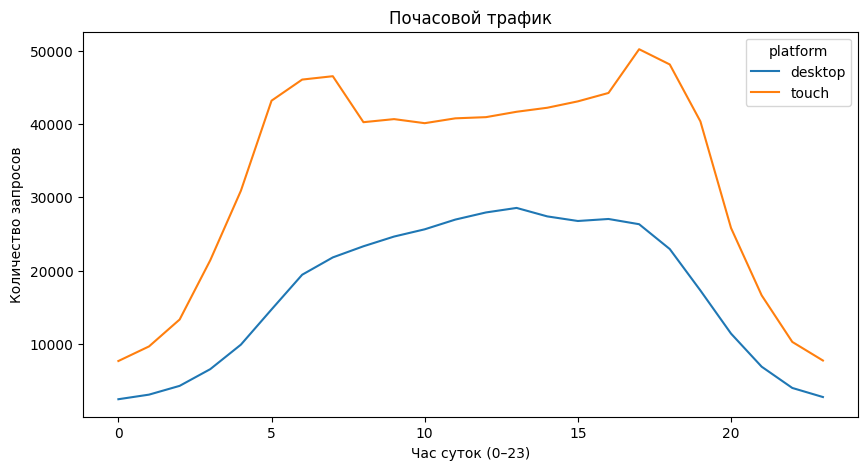

platform,desktop,touch
_hour,,
0,2396,7622
1,3023,9617
2,4224,13298
3,6510,21406
4,9863,30916
5,14674,43227
6,19423,46113
7,21791,46573
8,23314,40285


In [78]:
hourly = df.groupby(["platform","_hour"]).size().rename("count").reset_index()
hourly_pivot = hourly.pivot(index="_hour", columns="platform", values="count").fillna(0)

hourly_pivot.plot(figsize=(10,5), title="Почасовой трафик")
plt.xlabel("Час суток (0–23)")
plt.ylabel("Количество запросов")
plt.show()

hourly_pivot

### Шаг 7. Тематизация
Назначаем тематику по ключевым словам, считаем доли тем по платформам и ищем отличия.


In [79]:
themes = [
    ("video", ["ютуб","youtube","видео","кино","фильм","сериал","tv","ivi","okko","netflix","rutube"]),
    ("social", ["vk","вк","instagram","инстаграм","telegram","телеграм","tiktok","тик ток","одноклассники","facebook","фейсбук","twitter"]),
    ("music", ["музыка","песня","spotify","яндекс музыка","music","mp3","шазам"]),
    ("shopping", ["купить","цена","ozon","озон","wildberries","алиэкспресс","aliexpress","market","avito"]),
    ("maps_nav", ["карта","карты","maps","маршрут","навигатор","пробки","яндекс карты","google maps"]),
    ("news", ["новости","news","lenta","rbc","рбк","meduza","газета"]),
    ("games", ["игра","игры","game","steam","minecraft","roblox","dota","csgo","gta","valorant"]),
    ("education", ["википедия","wiki","реферат","урок","курс","математика","школа","университет"]),
    ("finance", ["банк","сбер","тинькофф","альфа","втб","курс доллара","биржа"]),
    ("email", ["почта","mail","gmail","яндекс почта","mail.ru"]),
    ("government", ["госуслуги","налог","штраф","мфц","пенсия"]),
    ("sports", ["спорт","матч","футбол","теннис"]),
    ("health", ["здоровье","симптом","болит","аптека","лечение","врач"]),
    ("tech", ["скачать","драйвер","windows","linux","программа","ошибка","discord"]),
    ("jobs", ["работа","вакансия","hh","резюме"]),
    ("food", ["рецепт","доставка еды","самокат","яндекс еда","еда"]),
    ("travel", ["билет","жд","поезд","самолет","отель","booking","такси","яндекс такси"]),
]

In [80]:
kw2theme = [(kw,theme) for theme,kws in themes for kw in kws]
kw2theme.sort(key=lambda x: len(x[0]), reverse=True)

In [81]:
def categorize_query(q: str) -> str:
    t = q.lower()
    for kw,theme in kw2theme:
        if kw in t: return theme
    return "other"

In [82]:
df["_theme"] = df["_query_lc"].apply(categorize_query)

In [83]:
theme_counts = df.groupby(["platform","_theme"]).size().rename("count").reset_index()
total_by_plat = theme_counts.groupby("platform")["count"].sum()
theme_counts["share"] = theme_counts.apply(lambda r: r["count"]/total_by_plat.loc[r["platform"]], axis=1)

In [84]:
theme_pivot = theme_counts.pivot(index="_theme", columns="platform", values="share").fillna(0)
theme_pivot["diff"] = theme_pivot["touch"] - theme_pivot["desktop"]
theme_pivot["abs_diff"] = theme_pivot["diff"].abs()

In [85]:
theme_pivot.sort_values("abs_diff", ascending=False).head(10)

platform,desktop,touch,diff,abs_diff
_theme,,,,
travel,0.021105,0.082299,0.061194,0.061194
other,0.913846,0.876959,-0.036887,0.036887
social,0.016753,0.008276,-0.008477,0.008477
maps_nav,0.016746,0.013118,-0.003628,0.003628
games,0.004449,0.001357,-0.003092,0.003092
education,0.004466,0.001460,-0.003005,0.003005
video,0.008545,0.006507,-0.002039,0.002039
email,0.001917,0.000212,-0.001705,0.001705
sports,0.003730,0.002801,-0.000929,0.000929


##  Итоги анализа

1. **Диапазон данных:** с 31.08.2021 по 21.09.2021.  
2. **Запросы «ютуб»:**  
   - desktop — 806  
   - touch — 732  
3. **ТОП-10:**  
   - Desktop: утилитарные и учебные запросы (календарь, таблицы, алфавит, картинки, обои).  
   - Touch: поздравления («с днём рождения …»), развлекательные и взрослые запросы.  
4. **Почасовой трафик:**  
   - Desktop активнее днём, пик в районе **13:00**.  
   - Touch активнее вечером, пик в районе **17:00**.  
5. **Тематики:**  
   - Travel заметно выше на touch (поиск билетов, такси).  
   - Desktop чаще используется для social, education, games.  
   - Большая доля попала в категорию *other* — это запросы, не покрытые словарём тематик.

---

Общий вывод: **desktop используется больше для учёбы и работы**,  
а **touch — для развлечений, общения и практических задач (поездки, поздравления, видео)**.
